# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import json

import xgboost as xgb

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pmdarima import auto_arima
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '\config-example.json', 'r') as f:
    config = json.load(f)

dataset_EDA_fname = config['DEFAULT']['dataset_EDA_fname']
processing_path = config['DEFAULT']['processing_path']
dataset_fname_suffix = config['DEFAULT']['dataset_fname_suffix']

In [32]:
client_data = pd.read_csv(os.path.join(processing_path,dataset_EDA_fname) + dataset_fname_suffix, header = 0, delimiter = ',')

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_24236\1981297199.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  client_data = pd.read_csv(os.path.join(processing_path,dataset_EDA_fname) + dataset_fname_suffix, header = 0, delimiter = ',')


In [33]:
client_data['StartDate'] = pd.to_datetime(client_data['StartDate'], infer_datetime_format=True)
client_data['StatusCreatedDate'] = pd.to_datetime(client_data['StatusCreatedDate'], infer_datetime_format=True)

# XGBoost

In [ ]:
data0 = data.groupby(['Season','StartDate','EventId','EventType'], as_index=False).agg(
                                                                                            Min_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            Max_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            )
data0['Max_Week'] = data0['Max_Purchase_Week_Date'].dt.week
data0['Min_Week'] = data0['Min_Purchase_Week_Date'].dt.week
data0['Purchase_Period_Week'] = (data0['Max_Week'] - data0['Min_Week']).abs()
data0                                                                                          

#### What is the purchase period for each event to the start date ?

In [34]:
data_week_purchase_period = client_data.groupby(['StartDate','Season','EventId'], as_index=False).agg(
                                                                                            Min_Purchase_Week_Date = pd.NamedAgg(column='Weeks to Event', aggfunc='min'),
                                                                                            Max_Purchase_Week_Date = pd.NamedAgg(column='Weeks to Event', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            )

# data_week_purchase_period['Max_Week'] = data_week_purchase_period['Max_Purchase_Week_Date'].dt.week
# data_week_purchase_period['Min_Week'] = data_week_purchase_period['Min_Purchase_Week_Date'].dt.week
data_week_purchase_period['Purchase_Period_Week'] = (data_week_purchase_period['Min_Purchase_Week_Date'] - data_week_purchase_period['Max_Purchase_Week_Date']).abs()
data_week_purchase_period



,StartDate,Season,EventId,Min_Purchase_Week_Date,Max_Purchase_Week_Date,Num_of_ticket,Purchase_Period_Week
0,2017-11-25 00:00:00,Autumn,14912,0.0,45.0,650,45.0
1,2017-11-25 00:00:00,Autumn,14948,0.0,24.0,604,24.0
2,2017-11-25 00:00:00,Autumn,14973,0.0,6.0,236,6.0
3,2017-11-27 00:00:00,Autumn,14824,0.0,46.0,1258,46.0
4,2017-11-28 00:00:00,Autumn,14923,0.0,46.0,706,46.0
...,...,...,...,...,...,...,...
1825,2022-12-03 00:00:00,Autumn,27139,5.0,5.0,2,0.0
1826,2022-12-05 16:00:00,Autumn,27224,2.0,2.0,2,0.0
1827,2022-12-09 00:00:00,Autumn,27024,4.0,12.0,3470,8.0
1828,2022-12-15 15:00:00,Autumn,27225,0.0,27.0,8,27.0


### Weekly Sales

In [10]:
data_weekly_ticket_sales = client_data.groupby(['EventId','StatusCreatedDate','StartDate','Weeks to Event'], as_index=False).agg(Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                                                                                )
data_weekly_ticket_sales

# data_weekly_ticket_sales = data.groupby(['StatusCreatedDate','StatusCreatedWeek','Season','EventType'], as_index=False).agg(
                                                                                            # Min_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            # Max_Purchase_Day = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            # Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            # )
# data_weekly_ticket_sales['Purchase_Period'] = (data_weekly_ticket_sales['Max_Purchase_Day'] - data_weekly_ticket_sales['Min_Purchase_Day']).dt.days
# data_weekly_ticket_sales)

,EventId,StatusCreatedDate,StartDate,Weeks to Event,Num_of_ticket
0,0,2020-03-03 15:23:00,2020-03-04 00:00:00,0.0,2
1,0,2020-03-27 17:31:00,2020-04-01 00:00:00,1.0,2
2,12595,2017-08-24 09:49:00,2019-10-13 00:00:00,111.0,2
3,14824,2017-01-11 16:00:00,2017-11-27 00:00:00,46.0,4
4,14824,2017-01-11 16:02:00,2017-11-27 00:00:00,46.0,2
...,...,...,...,...,...
213415,27368,2022-12-20 09:07:00,2023-01-17 14:30:00,4.0,2
213416,27368,2022-12-20 11:18:00,2023-01-17 14:30:00,4.0,2
213417,27368,2022-12-21 13:38:00,2023-01-17 14:30:00,4.0,2
213418,27368,2023-01-13 13:47:00,2023-01-17 14:30:00,1.0,2


In [11]:
pred_weekly_ticket_sales = data_weekly_ticket_sales.groupby(['Weeks to Event','EventId','StatusCreatedDate'], as_index=False).agg(Tot_Num_of_ticket = pd.NamedAgg(column='Num_of_ticket', aggfunc='sum'))

pred_weekly_ticket_sales

,Weeks to Event,EventId,StatusCreatedDate,Tot_Num_of_ticket
0,0.0,0,2020-03-03 15:23:00,2
1,0.0,14824,2017-11-23 01:01:00,2
2,0.0,14824,2017-11-23 05:31:00,2
3,0.0,14824,2017-11-23 06:31:00,2
4,0.0,14824,2017-11-23 06:47:00,2
...,...,...,...,...
213415,70.0,24934,2021-01-12 08:24:00,2
213416,70.0,25041,2021-01-10 17:21:00,2
213417,70.0,25041,2021-01-10 18:57:00,2
213418,70.0,25041,2021-01-10 21:09:00,2


In [12]:
new_df = data_weekly_ticket_sales.set_index('StatusCreatedDate')
pred_weekly_ticket_sales = new_df.resample('w').sum()
pred_weekly_ticket_sales = pred_weekly_ticket_sales.drop(columns=['EventId','Weeks to Event'])
pred_weekly_ticket_sales

,Num_of_ticket
StatusCreatedDate,
2017-01-15,308
2017-01-22,0
2017-01-29,0
2017-02-05,0
2017-02-12,162
...,...
2022-12-18,2
2022-12-25,6
2023-01-01,0


In [13]:
unique_events = data_weekly_ticket_sales.set_index('StatusCreatedDate')
df1 = unique_events['EventId'].resample('w').nunique()
df2 = unique_events.resample('w')['Num_of_ticket'].sum()
df3 = unique_events.resample('w')['Weeks to Event'].mean()
df = pd.concat([df1, df2, df3], axis=1)

df['Num_of_ticket(avg)'] = df['Num_of_ticket']/df['EventId']
df['Weeks to Event'] = df['Weeks to Event'].round()
# df['Weeks to Event'] = df['Weeks to Event'].replace(np.nan, 0)
df

,EventId,Num_of_ticket,Weeks to Event,Num_of_ticket(avg)
StatusCreatedDate,,,,
2017-01-15,10,308,49.0,30.8
2017-01-22,0,0,NaN,NaN
2017-01-29,0,0,NaN,NaN
2017-02-05,0,0,NaN,NaN
2017-02-12,9,162,44.0,18.0
...,...,...,...,...
2022-12-18,1,2,0.0,2.0
2022-12-25,1,6,4.0,6.0
2023-01-01,0,0,NaN,NaN


In [ ]:
v = data_weekly_ticket_sales.loc[data_weekly_ticket_sales['EventType'] == 'Seminar']
v.head(60)

Use an XGBoost model to predict the Sell Out Period (Days) and number of bookings (BookingReference). Consider 30 percent of
data for testing.

In [361]:
# Set the StartDate as index
# data1 =data1.set_index('StartDate')

### Weekly Sales 2

#### What is the weekly purchase distribution for each week to predict the weekly sales

We want to know the purchase distribution (StatusCreatedDate) for each EventId with unique start dates along with the weeks to event for when peaople started to buy the tickets.

In [38]:
weekly_ticket_sales = client_data.groupby(['StatusCreatedDate','StartDate','EventType','Weeks to Event'], as_index=False).agg(Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count'))

weekly_ticket_sales

,StatusCreatedDate,StartDate,EventType,Weeks to Event,Num_of_ticket
0,2017-01-11 16:00:00,2017-11-27 00:00:00,"Others, Group 1",46.0,4
1,2017-01-11 16:02:00,2017-11-27 00:00:00,"Others, Group 1",46.0,2
2,2017-01-11 16:20:00,2017-11-25 00:00:00,"Others, Group 1",45.0,2
3,2017-01-11 16:56:00,2017-11-27 00:00:00,"Others, Group 1",46.0,2
4,2017-01-11 17:14:00,2017-11-25 00:00:00,"Others, Group 1",45.0,2
...,...,...,...,...,...
211932,2022-12-20 09:07:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211933,2022-12-20 11:18:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211934,2022-12-21 13:38:00,2023-01-17 14:30:00,"Others, Group 10",4.0,2
211935,2023-01-13 13:47:00,2023-01-17 14:30:00,"Others, Group 10",1.0,2


In [36]:
# dfpred = weekly_ticket_sales.loc[weekly_ticket_sales['EventType'] == 'Seminar']
# dfpred

,StatusCreatedDate,StartDate,EventType,Weeks to Event,Num_of_ticket
143882,2021-01-09 01:12:00,2021-11-15 17:15:00,Seminar,44.0,2
143884,2021-01-09 06:04:00,2021-10-18 17:15:00,Seminar,40.0,2
143886,2021-01-09 08:05:00,2021-10-18 17:15:00,Seminar,40.0,2
143887,2021-01-09 08:06:00,2021-10-18 17:15:00,Seminar,40.0,2
143888,2021-01-09 08:07:00,2021-11-01 17:15:00,Seminar,42.0,2
...,...,...,...,...,...
210616,2022-07-06 23:24:00,2022-07-28 17:00:00,Seminar,3.0,2
210628,2022-07-07 10:20:00,2022-07-07 17:30:00,Seminar,0.0,2
210633,2022-07-07 11:30:00,2022-07-07 17:30:00,Seminar,0.0,2
210651,2022-07-07 15:15:00,2022-07-07 17:30:00,Seminar,0.0,2


We want to get the purchase distribution on a weekly basis across all years for all EventTypes to the weekst to Event start date for when people started purchasing. This shows the purchase distribution on a weekly basis towards the weeks started purchasing for an event.

In [39]:
df_new1 = weekly_ticket_sales.set_index('StatusCreatedDate')
df1 = df_new1.groupby(['Weeks to Event','EventType']).resample('w')['Num_of_ticket'].sum()
df1 = df1.to_frame().reset_index()
# df1 = df1.set_index('StatusCreatedDate')
df1

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket
0,0.0,Colloquium,2021-11-28,10
1,0.0,Colloquium,2021-12-05,0
2,0.0,Colloquium,2021-12-12,0
3,0.0,Colloquium,2021-12-19,0
4,0.0,Colloquium,2021-12-26,0
...,...,...,...,...
13407,66.0,Seminar,2021-02-14,2
13408,67.0,Seminar,2021-01-17,2
13409,70.0,Seminar,2021-01-10,10
13410,70.0,Seminar,2021-01-17,2


### Encoding Categorical Varibles
When training a machine learning model, all categorical variables must be convert into numeric form. Here, the `LabelEncoder` is used.

In [40]:
# Get all categorical variales
categorical_col1 = data_week_purchase_period.columns[data_week_purchase_period.dtypes == "object"].to_list()
categorical_col1

categorical_col2 = df1.columns[df1.dtypes == "object"].to_list()
categorical_col2

['EventType']

In [41]:
LE = LabelEncoder()

decode = pd.DataFrame(data_week_purchase_period[categorical_col1[0]].unique())
# decode1 = pd.DataFrame(data_week_purchase_period[categorical_col1[1]].unique())

for col1 in categorical_col1:
    # Transoform to numeric form
    data_week_purchase_period[col1] = LE.fit_transform(data_week_purchase_period[col1])
    

decoded = pd.DataFrame(data_week_purchase_period[categorical_col1[0]].unique())
# decoded1 = pd.DataFrame(data_week_purchase_period[categorical_col1[1]].unique())

final_df = pd.DataFrame()
final_df1 = pd.DataFrame()
final_df['decode'] = decode
final_df['decoded'] = decoded
# final_df1['decode1'] = decode1
# final_df1['decoded1'] = decoded1
print(final_df)
# print(final_df1)

   decode  decoded
0  Autumn        0
1  Winter        3
2  Spring        1
3  Summer        2


In [42]:
decode2 = pd.DataFrame(df1[categorical_col2[0]].unique())
# decode3 = pd.DataFrame(df1[categorical_col2[1]].unique())

for col2 in categorical_col2:
    # Transoform to numeric form
    df1[col2] = LE.fit_transform(df1[col2])

decoded2 = pd.DataFrame(df1[categorical_col2[0]].unique())
# decoded3 = pd.DataFrame(df1[categorical_col2[1]].unique())

final_df2 = pd.DataFrame()
final_df3 = pd.DataFrame()
final_df2['decode2'] = decode2
final_df2['decoded2'] = decoded2
# final_df3['decode3'] = decode3
# final_df3['decoded3'] = decoded3
print(final_df2)
# print(final_df3)

                   decode2  decoded2
0              Colloquium          0
1   Conference / Symposium         1
2               Exhibition         2
3                  Lecture         3
4        Lunchtime Lecture         4
5             Other Events         5
6          Others, Group 1         6
7         Others, Group 10         7
8          Others, Group 2         8
9          Others, Group 3         9
10         Others, Group 4        10
11         Others, Group 5        11
12         Others, Group 6        12
13         Others, Group 7        13
14         Others, Group 8        14
15         Others, Group 9        15
16           Reading Group        16
17       Research Training        17
18                 Seminar        18
19            Short Course        19
20           Summer School        20
21                Workshop        21


In [43]:
data_week_purchase_period.head(3)

,StartDate,Season,EventId,Min_Purchase_Week_Date,Max_Purchase_Week_Date,Num_of_ticket,Purchase_Period_Week
0,2017-11-25,0,14912,0.0,45.0,650,45.0
1,2017-11-25,0,14948,0.0,24.0,604,24.0
2,2017-11-25,0,14973,0.0,6.0,236,6.0


In [44]:
df1.head(3)

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket
0,0.0,0,2021-11-28,10
1,0.0,0,2021-12-05,0
2,0.0,0,2021-12-12,0


### Feature Collection

In [45]:
def create_features(df):
    '''
    Create time series features based on time series index
    '''
    
    df['StartMonth'] = df.StartDate.dt.month
    df['StartWeek'] = df.StartDate.dt.week
    df['StartHour'] = df.StartDate.dt.hour
    df['StartDayofWeek'] = df.StartDate.dt.dayofweek
    df['StartQuarter'] = df.StartDate.dt.quarter
    df['StartDayofyear'] = df.StartDate.dt.dayofyear
    df['StartMonth'] = df.StartDate.dt.month
    df['StartYear'] = df.StartDate.dt.year
    df['StartDayofMonth'] = df.StartDate.dt.day
    df['StartWeekofYear'] = df.StartDate.dt.weekofyear
    return df

In [46]:
def create_features1(df):
    '''
    Create time series features based on time series StatusCreatedDate.dt
    '''
    df['StatusCreatedMonth'] = df.StatusCreatedDate.dt.month
    df['StatusCreatedWeek'] = df.StatusCreatedDate.dt.week
    # df = df.copy()
    df['StatusCreatedHour'] = df.StatusCreatedDate.dt.hour
    df['StatusCreatedDayofWeek'] = df.StatusCreatedDate.dt.dayofweek
    df['StatusCreatedQuarter'] = df.StatusCreatedDate.dt.quarter
    df['StatusCreatedDayofyear'] = df.StatusCreatedDate.dt.dayofyear
    df['StatusCreatedMonth'] = df.StatusCreatedDate.dt.month
    df['StatusCreatedYear'] = df.StatusCreatedDate.dt.year
    df['StatusCreatedDayofMonth'] = df.StatusCreatedDate.dt.day
    df['StatusCreatedWeekofYear'] = df.StatusCreatedDate.dt.weekofyear
    return df

In [47]:
df1 = create_features1(df1)

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_24236\3992121174.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['StatusCreatedWeek'] = df.StatusCreatedDate.dt.week
C:\Users\KingRemy\AppData\Local\Temp\ipykernel_24236\3992121174.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['StatusCreatedWeekofYear'] = df.StatusCreatedDate.dt.weekofyear


In [48]:
data_week_purchase_period = create_features(data_week_purchase_period)

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_24236\3847920797.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['StartWeek'] = df.StartDate.dt.week
C:\Users\KingRemy\AppData\Local\Temp\ipykernel_24236\3847920797.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['StartWeekofYear'] = df.StartDate.dt.weekofyear


In [49]:
df1.head(3)

,Weeks to Event,EventType,StatusCreatedDate,Num_of_ticket,StatusCreatedMonth,StatusCreatedWeek,StatusCreatedHour,StatusCreatedDayofWeek,StatusCreatedQuarter,StatusCreatedDayofyear,StatusCreatedYear,StatusCreatedDayofMonth,StatusCreatedWeekofYear
0,0.0,0,2021-11-28,10,11,47,0,6,4,332,2021,28,47
1,0.0,0,2021-12-05,0,12,48,0,6,4,339,2021,5,48
2,0.0,0,2021-12-12,0,12,49,0,6,4,346,2021,12,49


In [1122]:
df1['StartYear'].value_counts(normalize=True)

2021    0.724178
2022    0.275822
Name: StartYear, dtype: float64

In [50]:
data_week_purchase_period.head(3)

,StartDate,Season,EventId,Min_Purchase_Week_Date,Max_Purchase_Week_Date,Num_of_ticket,Purchase_Period_Week,StartMonth,StartWeek,StartHour,StartDayofWeek,StartQuarter,StartDayofyear,StartYear,StartDayofMonth,StartWeekofYear
0,2017-11-25,0,14912,0.0,45.0,650,45.0,11,47,0,5,4,329,2017,25,47
1,2017-11-25,0,14948,0.0,24.0,604,24.0,11,47,0,5,4,329,2017,25,47
2,2017-11-25,0,14973,0.0,6.0,236,6.0,11,47,0,5,4,329,2017,25,47


### Train Test Split

In [51]:
# data_week_purchase_period = shuffle(data_week_purchase_period)
train_week_purchase_period, test_week_purchase_period = train_test_split(data_week_purchase_period, test_size=0.2,shuffle=False)

# train_week_purchase_period, test_week_purchase_period = train_test_split(data_week_purchase_period, test_size=0.1,shuffle=False)

In [52]:
# data_weekly_ticket_sales = shuffle(data_weekly_ticket_sales)
train_weekly_ticket_sales, test_weekly_ticket_sales = train_test_split(df1, test_size=0.3, shuffle=False)

In [409]:
# Split dataset for data_week_purchase_period
# split_size = int(0.7*len(data_week_purchase_period))

# train_week_purchase_period = data_week_purchase_period.iloc[:split_size, :]
# test_week_purchase_period = data_week_purchase_period.iloc[split_size:, :]

In [410]:
# Split dataset for data_weekly_ticket_sales
# split_size = int(0.7*len(data_weekly_ticket_sales))

# train_weekly_ticket_sales = data_weekly_ticket_sales.iloc[:split_size, :]
# test_weekly_ticket_sales = data_weekly_ticket_sales.iloc[split_size:, :]

In [371]:
# sns.set(rc={'figure.figsize':(12,10)})
# ax = sns.boxplot(data=data1, x='StartHour', y='Purchase_Period')
# ax.set_title('Event Start Dates Purchase Period')

### Creating Model

In [53]:
# train_week_purchase_period = create_features(train_week_purchase_period)
# test_week_purchase_period = create_features(test_week_purchase_period)
# StartDate	Season	EventId	Min_Purchase_Week_Date	Max_Purchase_Week_Date	Num_of_ticket	Purchase_Period_Week	StartHour	StartDayofWeek	StartQuarter	StartDayofyear	StartMonth	StartYear	StartDayofMonth	StartWeekofYear

FEATURES_P = ['Season','Num_of_ticket','StartHour','StartDayofWeek','StartQuarter','StartDayofyear','StartMonth','StartYear','StartDayofMonth','StartWeekofYear']
TARGET_P = 'Purchase_Period_Week'

In [54]:
# train_weekly_ticket_sales = create_features(train_weekly_ticket_sales)
# test_weekly_ticket_sales = create_features(test_weekly_ticket_sales)

# FEATURES_S = ['Season', 'StatusCreatedWeek', 'StatusCreatedYear', 'StatusCreatedMonth', 'EventType',
#        'Weeks to Event','Num_of_ticket', 'StatusCreatedHour', 'StatusCreatedDayofweek', 'StatusCreatedQuarter',
#        'StatusCreatedDayofyear']


FEATURES_S = ['StatusCreatedHour','EventType','StatusCreatedDayofWeek','StatusCreatedQuarter','StatusCreatedDayofyear','StatusCreatedMonth','StatusCreatedYear','StatusCreatedDayofMonth','StatusCreatedWeekofYear','Weeks to Event']
TARGET_S = 'Num_of_ticket'

In [55]:
# Creating X and y train and test
X_train_week_purchase_period = train_week_purchase_period[FEATURES_P]
y_train_week_purchase_period = train_week_purchase_period[TARGET_P]

X_test_week_purchase_period = test_week_purchase_period[FEATURES_P]
y_test_week_purchase_period = test_week_purchase_period[TARGET_P]

In [56]:
# Creating X and y train and test
X_train_weekly_ticket_sales = train_weekly_ticket_sales[FEATURES_S]
y_train_weekly_ticket_sales = train_weekly_ticket_sales[TARGET_S]

X_test_weekly_ticket_sales = test_weekly_ticket_sales[FEATURES_S]
y_test_weekly_ticket_sales = test_weekly_ticket_sales[TARGET_S]

In [57]:
reg_week_purchase_period = xgb.XGBRegressor(base_score=0.5, 
                                                # booster='gbtree',
                                                n_estimators=500, 
                                                early_stopping_rounds=50,
                                                learning_rate=0.01, 
                                                # objective='reg:linear', 
                                                # max_depth=3
                                                )
reg_week_purchase_period.fit(X_train_week_purchase_period, y_train_week_purchase_period, 
        eval_set=[(X_train_week_purchase_period, y_train_week_purchase_period), (X_test_week_purchase_period, y_test_week_purchase_period)],
        verbose=True)

[0]	validation_0-rmse:27.13299	validation_1-rmse:18.94193
[1]	validation_0-rmse:26.90334	validation_1-rmse:18.84800
[2]	validation_0-rmse:26.67660	validation_1-rmse:18.75484
[3]	validation_0-rmse:26.45160	validation_1-rmse:18.65983
[4]	validation_0-rmse:26.22933	validation_1-rmse:18.56563
[5]	validation_0-rmse:26.00964	validation_1-rmse:18.47275
[6]	validation_0-rmse:25.79215	validation_1-rmse:18.38118
[7]	validation_0-rmse:25.57767	validation_1-rmse:18.29050
[8]	validation_0-rmse:25.36523	validation_1-rmse:18.20078
[9]	validation_0-rmse:25.15456	validation_1-rmse:18.11386
[10]	validation_0-rmse:24.94664	validation_1-rmse:18.02795
[11]	validation_0-rmse:24.74116	validation_1-rmse:17.94187
[12]	validation_0-rmse:24.53755	validation_1-rmse:17.85783
[13]	validation_0-rmse:24.33639	validation_1-rmse:17.77305
[14]	validation_0-rmse:24.13739	validation_1-rmse:17.69155
[15]	validation_0-rmse:23.94079	validation_1-rmse:17.60631
[16]	validation_0-rmse:23.74658	validation_1-rmse:17.52489
[17]	va

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [58]:
reg_weekly_ticket_sales = xgb.XGBRegressor(base_score=0.5, 
                                                # booster='gbtree',
                                                n_estimators=1000, 
                                                early_stopping_rounds=50,
                                                learning_rate=0.01, 
                                                # objective='reg:linear', 
                                                # max_depth=3
                                                )
reg_weekly_ticket_sales.fit(X_train_weekly_ticket_sales, y_train_weekly_ticket_sales, 
        eval_set=[(X_train_weekly_ticket_sales, y_train_weekly_ticket_sales), (X_test_weekly_ticket_sales, y_test_weekly_ticket_sales)],
        verbose=True)

[0]	validation_0-rmse:257.07870	validation_1-rmse:71.24487
[1]	validation_0-rmse:255.80813	validation_1-rmse:71.19877
[2]	validation_0-rmse:254.54534	validation_1-rmse:71.15383
[3]	validation_0-rmse:253.30331	validation_1-rmse:71.11003
[4]	validation_0-rmse:252.06936	validation_1-rmse:71.06736
[5]	validation_0-rmse:250.84949	validation_1-rmse:71.02578
[6]	validation_0-rmse:249.65218	validation_1-rmse:70.98529
[7]	validation_0-rmse:248.46238	validation_1-rmse:70.94585
[8]	validation_0-rmse:247.25370	validation_1-rmse:70.89713
[9]	validation_0-rmse:246.05803	validation_1-rmse:70.85267
[10]	validation_0-rmse:244.87460	validation_1-rmse:70.80938
[11]	validation_0-rmse:243.70352	validation_1-rmse:70.76723
[12]	validation_0-rmse:242.54462	validation_1-rmse:70.72619
[13]	validation_0-rmse:241.39825	validation_1-rmse:70.68625
[14]	validation_0-rmse:240.26335	validation_1-rmse:70.65131
[15]	validation_0-rmse:239.14102	validation_1-rmse:70.61347
[16]	validation_0-rmse:238.03015	validation_1-rmse

XGBRegressor(base_score=0.5, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Features Importance

In [59]:
fi = pd.DataFrame(data=reg_week_purchase_period.feature_importances_,
                index=reg_week_purchase_period.feature_names_in_,
                columns=['importance'])

In [60]:
fi1 = pd.DataFrame(data=reg_weekly_ticket_sales.feature_importances_,
                index=reg_weekly_ticket_sales.feature_names_in_,
                columns=['importance'])

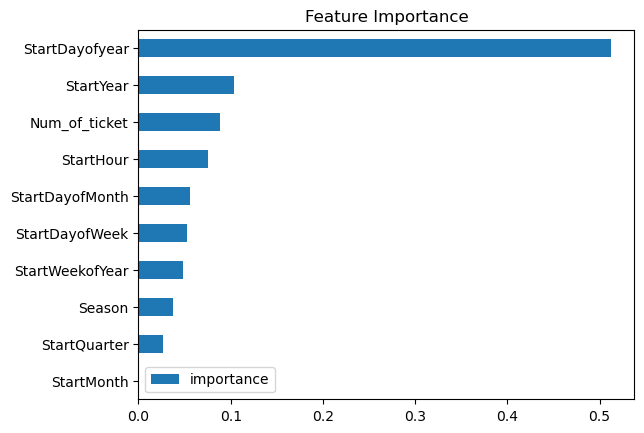

In [61]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

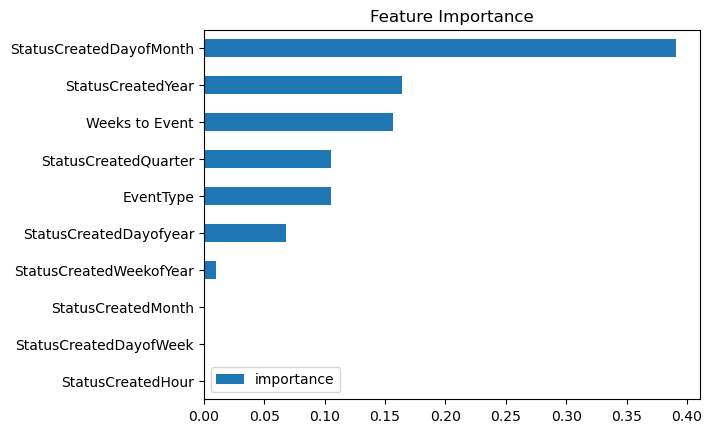

In [62]:
fi1.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [63]:
test_week_purchase_period['XGB_Purchase_period'] = reg_week_purchase_period.predict(X_test_week_purchase_period)


In [64]:
test_weekly_ticket_sales['XGB_NumofTicket'] = reg_weekly_ticket_sales.predict(X_test_weekly_ticket_sales)

### Storing Predictions

### Forcast on Test

In [ ]:
test_week_purchase_period['XGB_Purchase_period'] = reg_week_purchase_period.predict(X_test_week_purchase_period)
data_week_purchase_period = data_week_purchase_period.merge(test_week_purchase_period[['XGB_Purchase_period']], how='left', left_index=True, right_index=True)
ax = data_week_purchase_period[['XGB_Purchase_period']].plot(figsize=(15,5))
data_week_purchase_period['XGB_Purchase_period'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'XGB_Purchase_period'])
ax.set_title('Raw Purchase Period Data and Predictions')
plt.show()

In [ ]:
# test_weekly_ticket_sales['XGB_NumofTicket'] = reg_weekly_ticket_sales.predict(X_test_weekly_ticket_sales)
df1 = df1.merge(test_weekly_ticket_sales[['XGB_NumofTicket']], how='left', left_index=True, right_index=True)
ax = df1[['Num_of_ticket']].plot(figsize=(15,5))
test_weekly_ticket_sales['XGB_NumofTicket'].plot(legend=True)
plt.legend(['Num_of_Tickets', 'XGB_NumofTicket'])
ax.set_title("Raw Num of Tickets and Predicted Num of Tickets")
plt.show()

Text(0.5, 1.0, 'Purchase Period per Event - XGBoost')

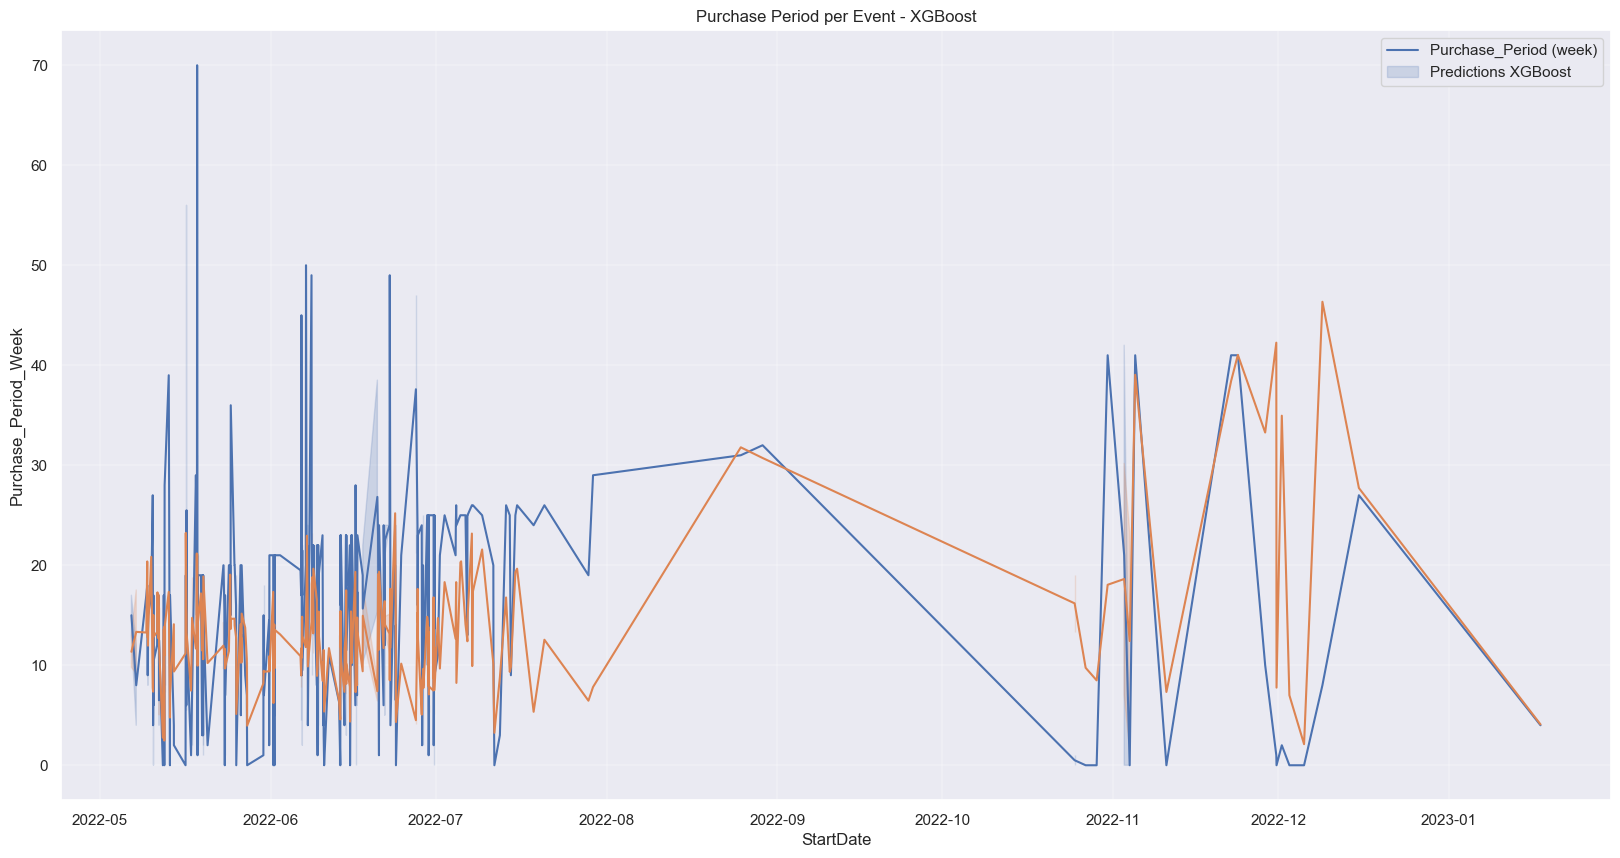

In [65]:
sns.set(rc={'figure.figsize':(20,10)})
# data_week_purchase_period = data_week_purchase_period.merge(test_week_purchase_period[['XGB_Purchase_period']], how='left', left_index=True, right_index=True)
sns.lineplot(x = test_week_purchase_period['StartDate'], y = test_week_purchase_period['Purchase_Period_Week'],data= test_week_purchase_period)
sns.lineplot(x = test_week_purchase_period['StartDate'], y = test_week_purchase_period['XGB_Purchase_period'],data= test_week_purchase_period)

plt.grid(linestyle='-',linewidth=0.3)
plt.legend(labels=['Purchase_Period (week)','Predictions XGBoost'])
plt.title('Purchase Period per Event - XGBoost')
# plt.legend(labels=['Purchase_Period_Pred', 'Purchase_Period'])

In [1079]:
df2 = df1.merge(test_weekly_ticket_sales[['XGB_NumofTicket']], how='left', left_index=True, right_index=True)
df1

,Weeks to Event,StatusCreatedDate,Num_of_ticket,StartHour,StartDayofWeek,StartQuarter,StartDayofyear,StartMonth,StartYear,StartDayofMonth,StartWeekofYear,XGB_NumofTicket
0,0.0,2021-01-10,21,0,6,1,10,1,2021,10,1,NaN
1,0.0,2021-01-17,144,0,6,1,17,1,2021,17,2,NaN
2,0.0,2021-01-24,0,0,6,1,24,1,2021,24,3,NaN
3,0.0,2021-01-31,0,0,6,1,31,1,2021,31,4,NaN
4,0.0,2021-02-07,0,0,6,1,38,2,2021,7,5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3461,94.0,2021-02-07,0,0,6,1,38,2,2021,7,5,2.740293
3462,94.0,2021-02-14,1,0,6,1,45,2,2021,14,6,6.007633
3463,98.0,2021-01-10,5,0,6,1,10,1,2021,10,1,2.964990
3464,98.0,2021-01-17,3,0,6,1,17,1,2021,17,2,6.140961


Text(0.5, 1.0, 'Raw Num of Tickets and Predicted Num of Tickets - XGBoost')

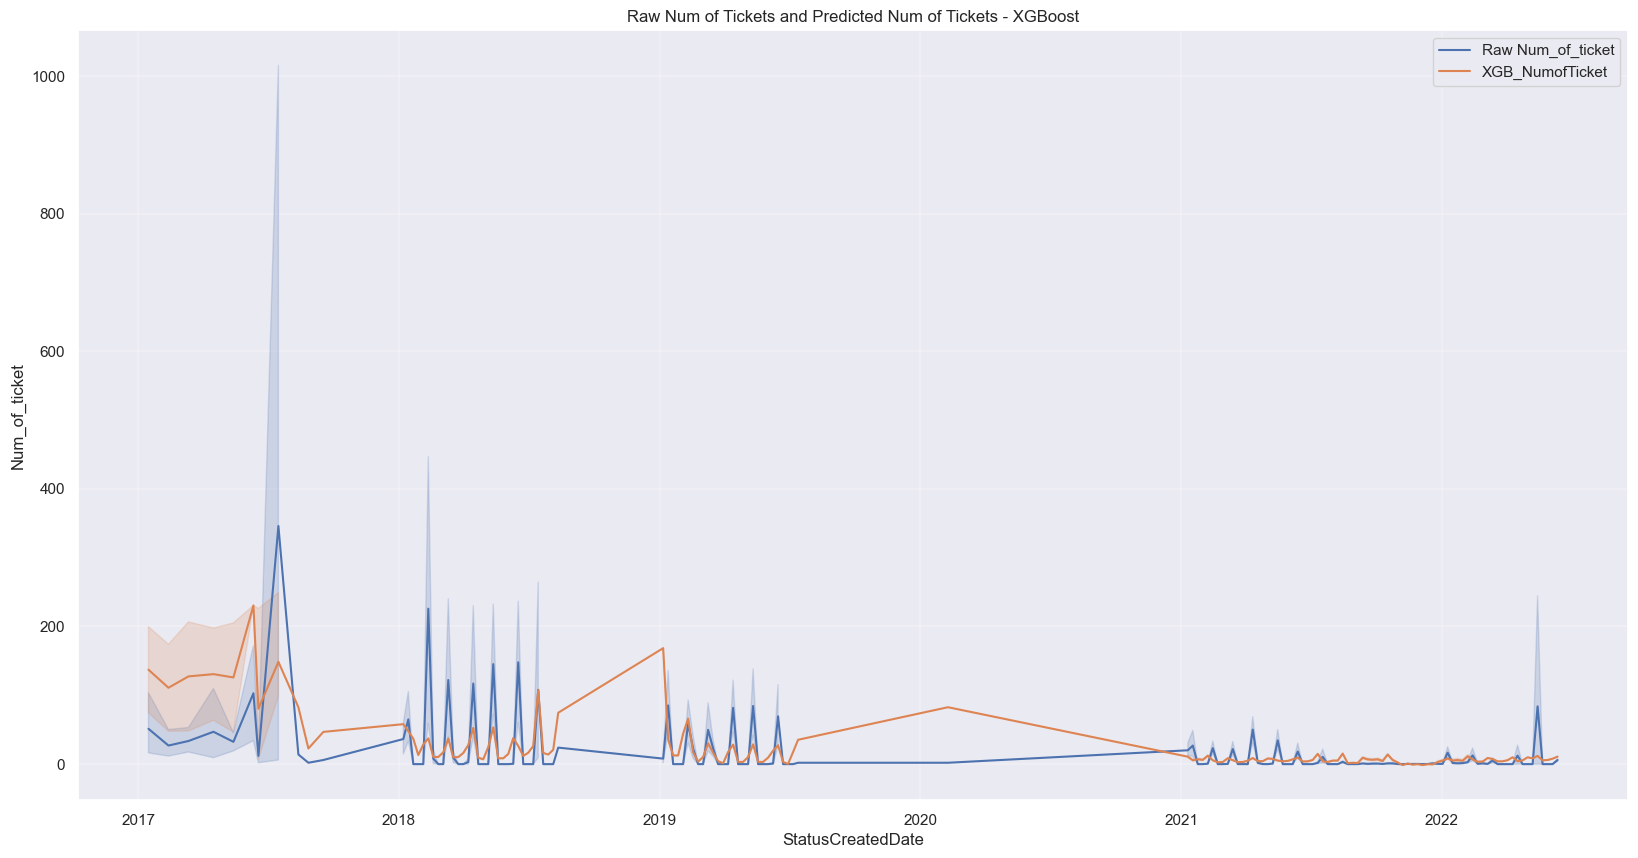

In [66]:
# sns.set(rc={'figure.figsize':(20,10)})

ax = sns.lineplot(x = 'StatusCreatedDate', y = 'Num_of_ticket',data= test_weekly_ticket_sales, label="Raw Num_of_ticket")
ax2 = sns.lineplot(x = 'StatusCreatedDate', y = 'XGB_NumofTicket',data= test_weekly_ticket_sales, label="XGB_NumofTicket")

plt.grid(linestyle='-',linewidth=0.3)
plt.legend()
plt.title('Raw Num of Tickets and Predicted Num of Tickets - XGBoost')

Text(0.5, 1.0, 'Raw Num of Tickets and Predicted Num of Tickets (Weeks to Event) - XGBoost')

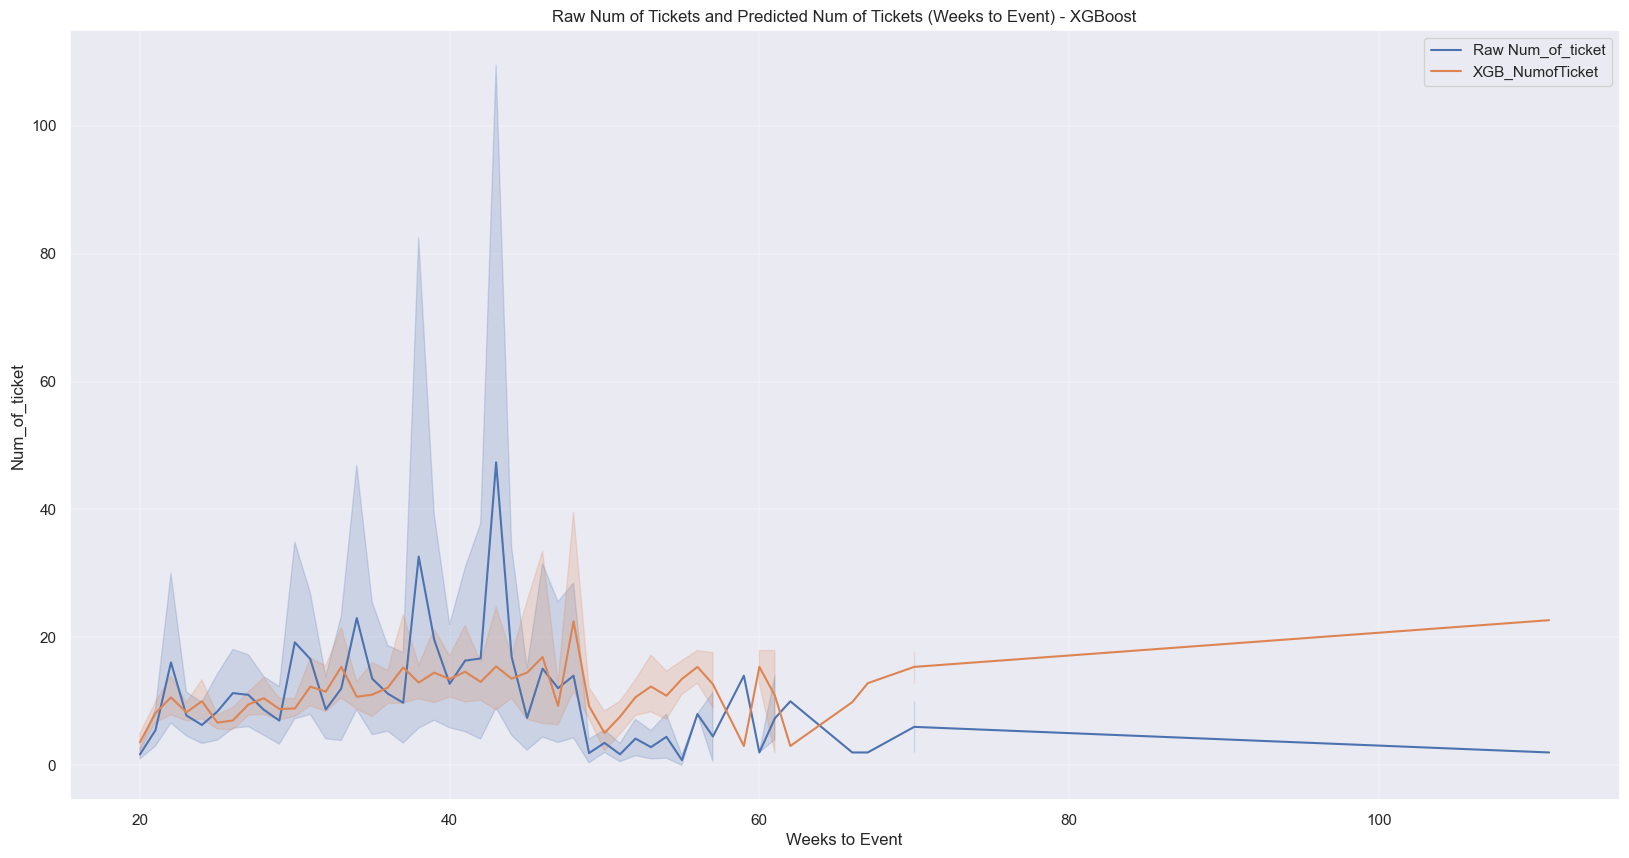

In [67]:
ax = sns.lineplot(x = test_weekly_ticket_sales['Weeks to Event'], y = test_weekly_ticket_sales['Num_of_ticket'],data= test_weekly_ticket_sales, label="Raw Num_of_ticket")
ax2 = sns.lineplot(x = test_weekly_ticket_sales['Weeks to Event'], y = test_weekly_ticket_sales['XGB_NumofTicket'],data= test_weekly_ticket_sales, label="XGB_NumofTicket")

plt.grid(linestyle='-',linewidth=0.3)
plt.legend()
plt.title('Raw Num of Tickets and Predicted Num of Tickets (Weeks to Event) - XGBoost')

Save model

In [72]:
reg_week_purchase_period.save_model("purchase_period_model.json")
reg_weekly_ticket_sales.save_model("weekly_sales_model.json")

Load model

In [73]:
model_period = xgb.Booster()
model_period.load_model("purchase_period_model.json")